In [404]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ast import literal_eval

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
# metrics for each class + weighted average (- bad impact)
# micro f1 = accuracy
def print_metrics(cls, X_test, y_test):
    sns.heatmap(confusion_matrix(y_test, cls.predict(X_test)), annot=True, fmt='g', annot_kws={"size": 16})
    print('accuracy: ',metrics.accuracy_score(y_test, cls.predict(X_test)))
    print()
    print(metrics.classification_report(y_test, cls.predict(X_test)))
    print('macro precision: ',metrics.precision_score(y_test, cls.predict(X_test), average='macro'))
    print('micro precision: ',metrics.precision_score(y_test, cls.predict(X_test), average='micro'))
    print()
    print('micro recall: ',metrics.recall_score(y_test, cls.predict(X_test), average='micro'))
    print('macro recall: ',metrics.recall_score(y_test, cls.predict(X_test), average='macro'))
    print()
    print('micro f1: ',metrics.f1_score(y_test, cls.predict(X_test), average='micro'))
    print('macro f1: ',metrics.f1_score(y_test, cls.predict(X_test), average='macro'))
    plt.show()

# Natural language processing (NLP)

Dataset contains descriptions of projects. These are in HTML format as they were obtained by web scraping. Projects are from different countries and therefore their descriptions can be written in different languages.

We wrote a module for text extraction from HTML using BeautifulSoup and for language detection using Google Translate API based on first and last 100 characters of each description (as we are sure that some projects are written in more languages).

Module can only be run with Python 2 version as version 3 is not supported by Google API yet. We run scripts in CLI multiple times to detect languages of all projects in train, test and validation sets (as daily limit is 2 000 000 characters).

Resulting datasets are stored on path: data/split/nlp/

In [502]:
x = pd.read_csv('data/split/nlp/train.csv', index_col=0)

In [505]:
x.shape

(18296, 56)

## Analysis

Firstly we will analyze how many descriptions are written in non-english so we can translate them into english using Google API if necessary. We will also analyze how language affects project success.

In [6]:
# plots 4 barplots
# from them we can find answers to the following questions:

def barplot_with_percentages(df, column, x=10, y=6):
    fig, ax = plt.subplots(2, 2)
    
    # --- first row -- 
    
    # how many people with different 'column' are negative and how many are discordant?
    pd.crosstab(df[column], df['class']).plot.bar(ax=ax[0, 0], figsize=(20, 10))
    
    # what portion of people with different 'column' is negative and what portion is discordant?
    pd.crosstab(df[column], df['class']).apply(lambda x: x/x.sum(), axis=1).plot.bar(ax=ax[0, 1])
    for p in ax[0, 1].patches:
        ax[0, 1].annotate(str(round(p.get_height(), 2)), (p.get_x(), p.get_height()))
    
    # --- second row --
    
    # how many negative belongs to different 'column'?
    # how many discordant belongs to different 'column'?
    pd.crosstab(df['class'], df[column]).plot.bar(ax=ax[1, 0])
    
    # what portion of negative belongs to different 'column'
    # what portion of discordant belongs to different 'column'
    pd.crosstab(df['class'], df[column]).apply(lambda x: x/x.sum(), axis=1).plot.bar(ax=ax[1, 1])
    for p in ax[1, 1].patches:
        ax[1, 1].annotate(str(round(p.get_height(), 2)), (p.get_x(), p.get_height()))

In [4]:
df[['text', 'lang_1', 'conf_1', 'lang_2', 'conf_2']].sample(10)

,text,lang_1,conf_1,lang_2,conf_2
14021,"""BOTTOMS UP! True Tales of Hitting Rock-Bottom...",en,1.000000,en,1.000000
15961,FAMILY MAN is a 288 page graphic novel writte...,en,1.000000,en,1.000000
7533,Hi there!This campaign has 1 REWARD TIER with ...,en,1.000000,en,1.000000
6844,The descendant of the goddess Athena with the...,en,1.000000,en,1.000000
2053,I want to create a label that will give musica...,en,1.000000,en,1.000000
5771,Hello ! My name is Stanislav Benkov and I am 2...,en,1.000000,en,1.000000
18088,The artists:Kirrilee Bailey (AU)Zoe Bastin (AU...,en,0.700550,en,1.000000
16512,(FRANÃÂAIS CI-DESSOUS)Blockchain Wordwide : ...,en,0.923652,lb,0.751452
11473,"Stretch DY5TOPIA - $55,555 unlocks the Monochr...",en,1.000000,en,1.000000
6951,A Public Servant with a VisionIn the Summer of...,en,1.000000,en,1.000000


### Language detected using first 100 characters of description

In [5]:
df['lang_1'].value_counts()

en     17316
es       342
fr       204
de       176
und      104
it        59
sv        33
nl        15
no        13
da        11
hu         2
co         2
id         2
fy         2
haw        2
ja         2
ca         2
ro         1
pt         1
jw         1
is         1
hi         1
la         1
el         1
cy         1
gl         1
Name: lang_1, dtype: int64

In [21]:
# distinguish only english and other
df['lang_1_new'] = df['lang_1'].apply(lambda x: 'en' if x == 'en' else 'other')
df['lang_1_new'].value_counts()

en       17316
other      980
Name: lang_1_new, dtype: int64

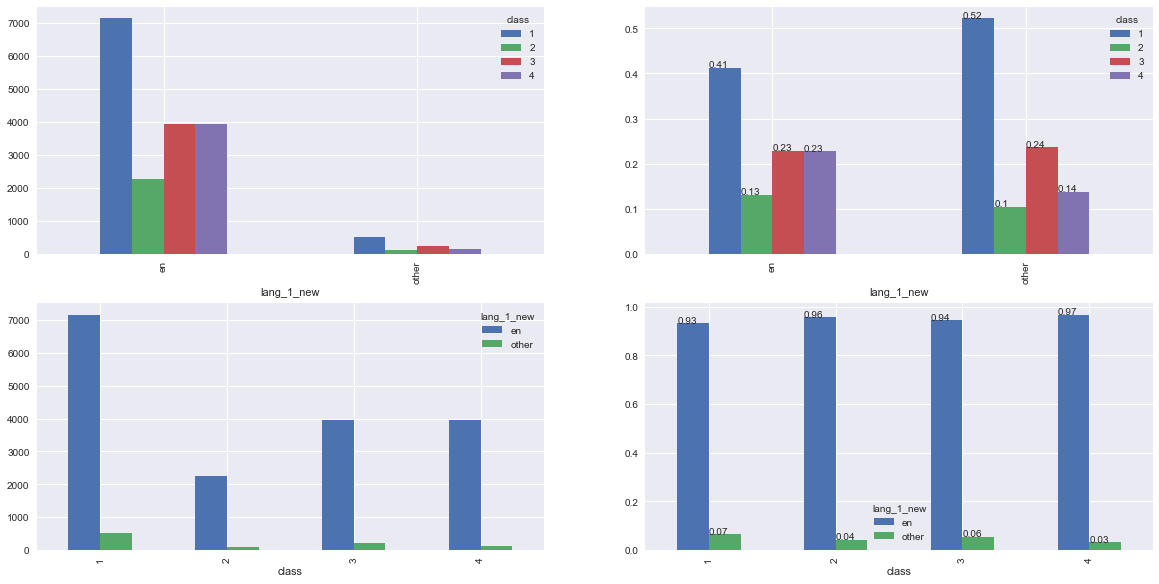

In [11]:
barplot_with_percentages(df, 'lang_1_new')

### Language detected using last 100 characters of description

In [12]:
df['lang_2'].value_counts()

en       17152
es         309
fr         225
de         196
und        167
it          71
sv          35
nl          23
da          17
no          13
pt           8
ca           6
fy           4
pl           4
eu           3
gl           3
ru           3
cy           3
tr           3
mg           3
ro           3
sk           3
ht           3
lb           3
hi           3
hr           2
hu           2
so           2
et           2
zu           2
co           2
ms           2
id           2
fi           2
tl           2
jw           1
sn           1
zh-CN        1
bg           1
ar           1
ig           1
el           1
la           1
vi           1
lt           1
ga           1
af           1
ja           1
Name: lang_2, dtype: int64

In [20]:
# distinguish only english and other
df['lang_2_new'] = df['lang_2'].apply(lambda x: 'en' if x == 'en' else 'other')
df['lang_2_new'].value_counts()

en       17152
other     1144
Name: lang_2_new, dtype: int64

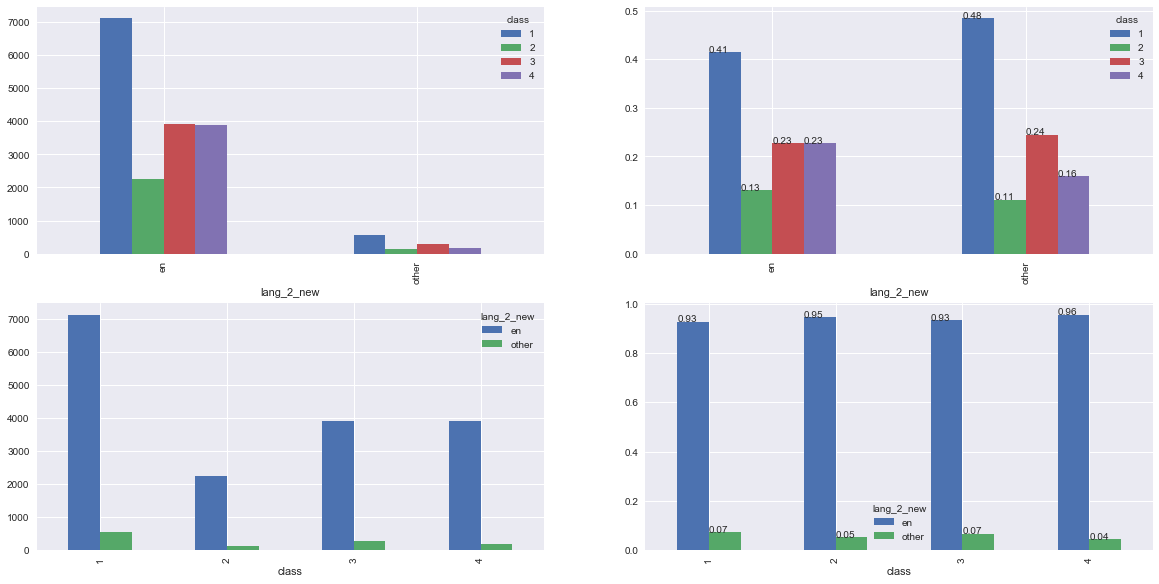

In [14]:
barplot_with_percentages(df, 'lang_2_new')

### Is at least one of the languages english?

In [19]:
df['lang_new'] = df.apply(lambda x: 'en' if (x['lang_1'] == 'en' or x['lang_2'] == 'en') else 'other', axis=1)
df['lang_new'].value_counts()

en       17541
other      755
Name: lang_new, dtype: int64

In [28]:
# non-english descriptions sample
df[df['lang_new'] == 'other']['text'].sample(20)

148      Decidimos emprender un restaurante de Helados ...
2996                                                      
13915    Salut Tous! 12 ans dÃÂ©j que je me suis lancÃ...
8062     ACHTUNG! Gestern funktionierte die Kickstarter...
8456     Cuando alguien se acerca a Scrum, el marco ÃÂ...
8525                                                      
4605     El Proyecto esta destinado para las nuevas gen...
7504     COMO NACE CAFÃÂ CANELA?Es una proyecto famil...
15955    alter schwarzmarkthier kÃÂ¶nnte eine typische...
11038    Nous Voulons CrÃÂ©er Une SÃÂ©rie Horreur , S...
13062    Team DJSTeam DJS esta lanzando una campa?a de ...
3891     Giunti alla settima edizione abbiamo deciso di...
1784     Sehr geehrte Damen und Herren,Ich mÃÂ¶chte Ih...
1065                                                      
12314    Hallo, Mein Name ist Stephan P. Ich bin gelern...
10721    Wir haben unser bestehendes grafisches Symbol ...
5804     Bonjour/Bonsoir, et tout d'abord merci vous de.

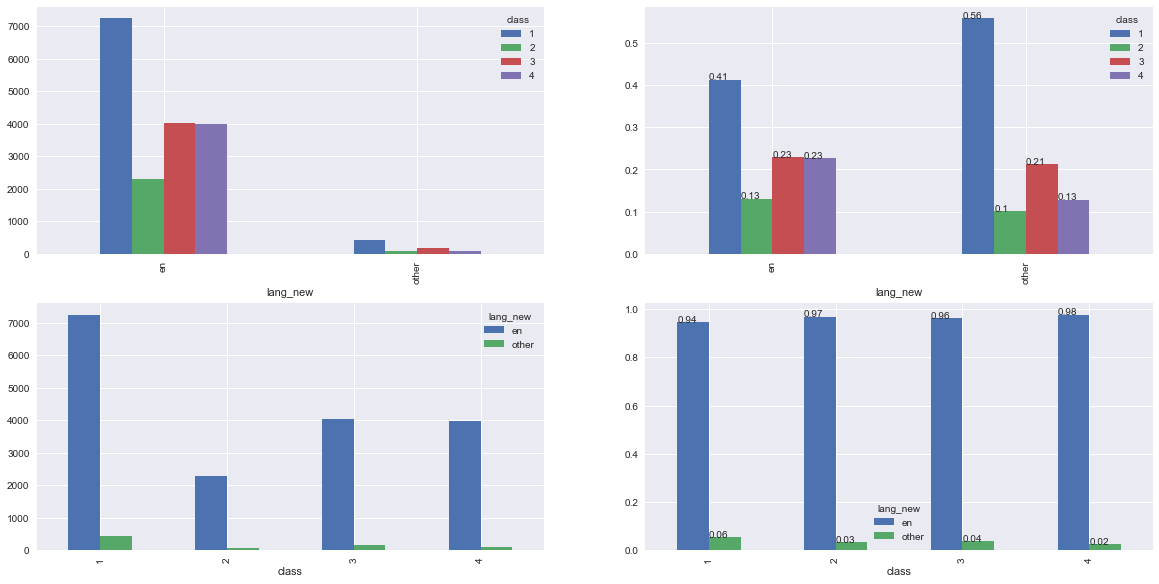

In [26]:
barplot_with_percentages(df, 'lang_new')

As we can see from the above figure, non-english descriptions tend to be less successful:
* 41% of projects with descriptions containing english part fail completely
* 23% of projects with descriptions containing english part are very successful

While

* 56% of projects with descriptions written only in other languages fail completely
* 13% of projects with descriptions written only in other languages are very successful

Only about 4% of descriptions do not contain english parts.

## Feature extraction

We will use methods of NLP to extract features from descriptions (Bag of words model). Approach:

1. tokenization
2. stopwords removal
3. lemmatization
4. tf-idf calculation
5. dimensionality reducion with LSA

In [123]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = [16, 6]

In [20]:
# use only letter-like tokens
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

In [34]:
df['tokens'] = df['text'].apply(lambda document: tokenizer.tokenize(document.lower()))
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stopwords.words('english')])
df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
df.to_csv('data/split/nlp/train_tokens.csv')

In [46]:
# test set
df_test = pd.read_csv('data/split/nlp/test.csv', index_col=0)

df_test['tokens'] = df_test['text'].apply(lambda document: tokenizer.tokenize(document.lower()))
df_test['tokens'] = df_test['tokens'].apply(lambda tokens: [token for token in tokens if token not in stopwords.words('english')])
df_test['tokens'] = df_test['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

df_test.to_csv('data/split/nlp/test_tokens.csv')

In [ ]:
# validation set
df_cv = pd.read_csv('data/split/nlp/cv.csv', index_col=0)

df_cv['tokens'] = df_cv['text'].fillna('').apply(lambda document: tokenizer.tokenize(document.lower()))
df_cv['tokens'] = df_cv['tokens'].apply(lambda tokens: [token for token in tokens if token not in stopwords.words('english')])
df_cv['tokens'] = df_cv['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

df_cv.to_csv('data/split/nlp/cv_tokens.csv')

### Let's see how many tokens do projects have.

In [2]:
df = pd.read_csv('data/split/nlp/train_tokens.csv', index_col=0, encoding='latin1')

In [3]:
# tokens column is treated as string
df['tokens'] = df['tokens'].apply(lambda x: literal_eval(x))

In [4]:
tokens_len = df['tokens'].apply(lambda x: len(x))

In [5]:
tokens_len.describe()

count    18296.000000
mean       334.147081
std        350.508884
min          0.000000
25%        112.000000
50%        223.000000
75%        430.000000
max       5120.000000
Name: tokens, dtype: float64

In [6]:
tokens_len.sort_values(ascending=False).head()

808      5120
5372     4496
15161    4496
6942     3990
15534    3990
Name: tokens, dtype: int64

In [7]:
# many tokens due to language
df.loc[808, ['url_name', 'lang_new']]

url_name    postcard-from-paradise
lang_new                     other
Name: 808, dtype: object

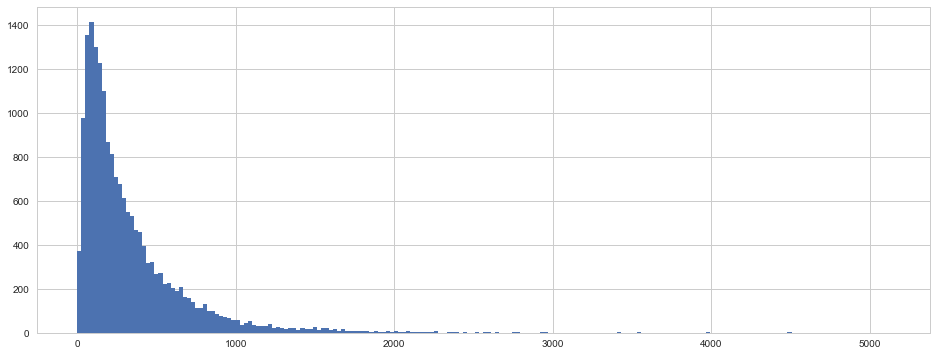

In [97]:
tokens_len.hist(bins=200)

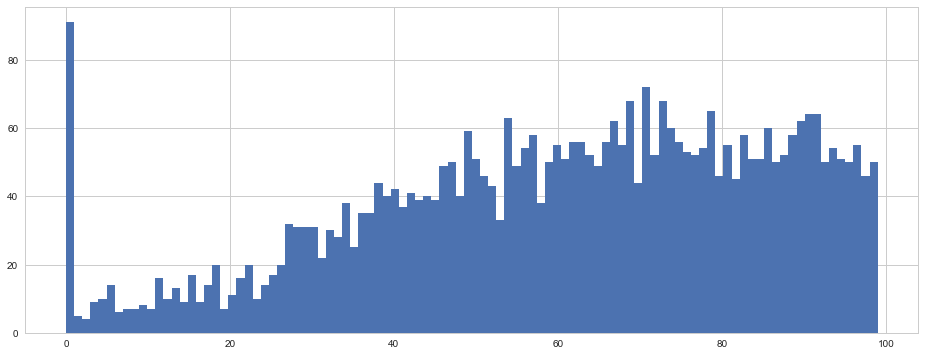

In [84]:
tokens_len[tokens_len<100].hist(bins=100)

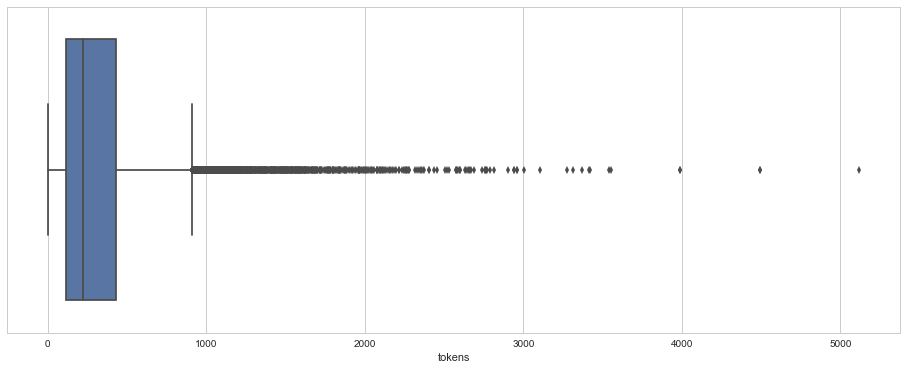

In [85]:
sns.boxplot(tokens_len)

### Document frequency

In [11]:
doc_freq = defaultdict(int)

for tokens in df['tokens']:
    for unique_token in set(tokens):
        doc_freq[unique_token] += 1

In [12]:
# number of unique tokens in all documents
len(doc_freq)

235081

In [14]:
doc_freq_series = pd.Series(doc_freq)

In [16]:
doc_freq_series.sort_values(ascending=False)

one                9839
make               9579
help               9478
time               9392
also               8984
year               8894
project            8818
need               8798
like               8310
get                8251
new                8225
u                  8127
work               8075
first              7868
want               7392
people             7141
world              6986
life               6596
way                6585
many               6507
see                6441
well               6429
would              6413
go                 6318
support            6254
goal               6210
kickstarter        6184
take               6111
come               6005
love               5781
                   ... 
momona                1
momokahachi           1
momofuku              1
momoe                 1
mommos                1
mommo?                1
mommo                 1
monaghan              1
monaki                1
mondaines             1
monatliche      

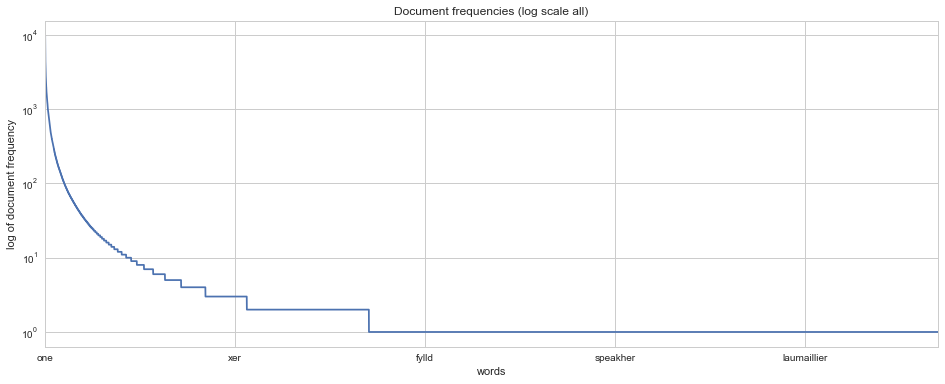

In [92]:
doc_freq_series.sort_values(ascending=False).plot()
plt.yscale('log')
plt.title('Document frequencies (log scale all)')
plt.xlabel('words')
plt.ylabel('log of document frequency')

In [129]:
(doc_freq_series / len(df)).describe()

count    235081.000000
mean          0.000881
std           0.008581
min           0.000055
25%           0.000055
50%           0.000055
75%           0.000109
max           0.537768
dtype: float64

(0, 10000)

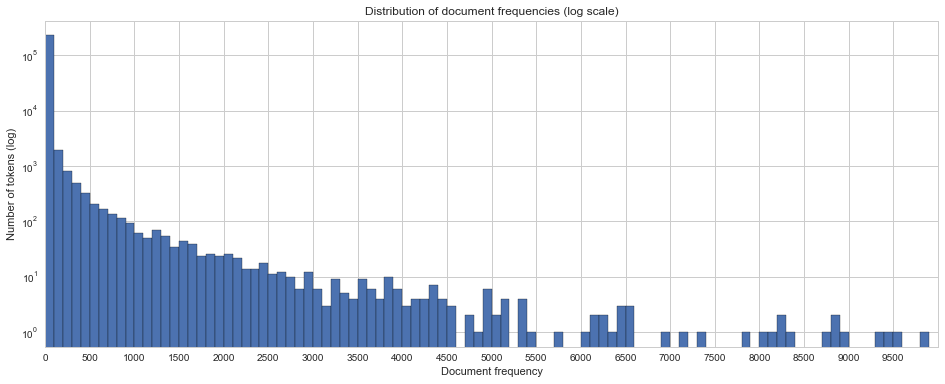

In [197]:
doc_freq_series.plot(kind='hist', bins=np.arange(0, 10000, 100), ec='black')
plt.yscale('log')
plt.title('Distribution of document frequencies (log scale)')
plt.xlabel('Document frequency')
plt.ylabel('Number of tokens (log)')
plt.xticks(np.arange(0, 10000, 500))
plt.xlim(0, 10000)

### Find interval of document frequency for tf-idf

(20, 500)

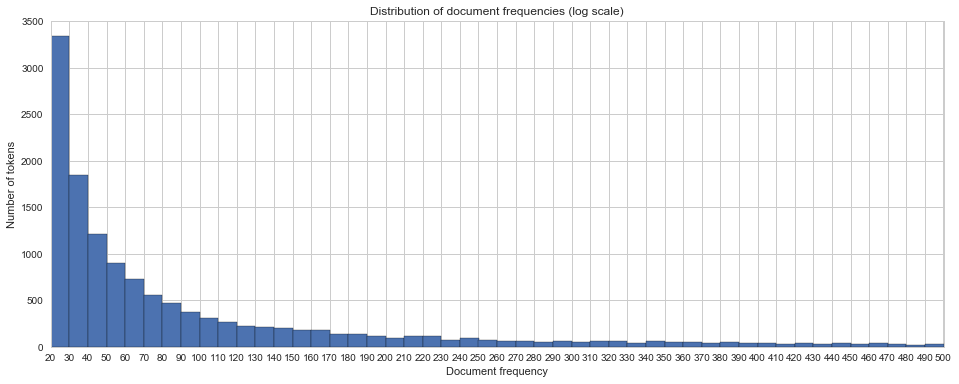

In [418]:
min_df = 20 # at least 20 documents must contain term
max_df = 500 # maximum of 500 documents must contain term
step = 10 # plot step
doc_freq_series[(doc_freq_series >= min_df) & (doc_freq_series <= max_df)].plot(kind='hist', bins=np.arange(min_df, max_df + step, step), ec='black')
#plt.yscale('log')
plt.title('Distribution of document frequencies (log scale)')
plt.xlabel('Document frequency')
plt.ylabel('Number of tokens')
plt.xticks(np.arange(min_df, max_df + step, step))
plt.xlim(min_df, max_df)

In [419]:
# how many tokens are in the interval
len(doc_freq_series[(doc_freq_series >= min_df) & (doc_freq_series <= max_df)])

13051

In [420]:
# calculate percentage of projects
min_df = min_df / len(df)
min_df

0.0010931351114997813

In [421]:
# calculate percentage of projects
max_df = max_df / len(df)
max_df

0.027328377787494536

### Calculate tf-idf

We used two configurations of tf-idf:
1. length = 14 411
    1. min_df = 0.0010931351114997813 which equals to 20 documents at least
    2. max_df = 1.0 which equals to 18 296 documents at most
    
    
2. length = 13 007
    1. min_df = 0.0010931351114997813 which equals to 20 documents at least
    2. max_df = 1.0 which equals to 18 296 documents at most

In [306]:
df = pd.read_csv('data/split/nlp/train_tokens.csv', index_col=0, encoding='latin1')
df['tokens'] = df['tokens'].apply(lambda x: literal_eval(x))

In [307]:
vectorizer = TfidfVectorizer(preprocessor=' '.join, ngram_range=(1,1), min_df=min_df)

df['tf-idf'] = list(vectorizer.fit_transform(df['tokens']).toarray())

In [308]:
len(vectorizer.vocabulary_)

14411

In [309]:
# create new columns of tf-idf
for token, i in vectorizer.vocabulary_.items():
    df['token_'+token] = df['tf-idf'].apply(lambda x: x[i])

In [310]:
df.to_csv('data/split/nlp/train_tfidf.csv')

In [311]:
# same for test set
df_test = pd.read_csv('data/split/nlp/test_tokens.csv', index_col=0, encoding='latin1')
df_test['tokens'] = df_test['tokens'].apply(lambda x: literal_eval(x))

df_test['tf-idf'] = list(vectorizer.transform(df_test['tokens']).toarray())
for token, i in vectorizer.vocabulary_.items():
    df_test['token_'+token] = df_test['tf-idf'].apply(lambda x: x[i])
    
df_test.to_csv('data/split/nlp/test_tfidf.csv')

In [312]:
# same for validation set
df_cv = pd.read_csv('data/split/nlp/cv_tokens.csv', index_col=0, encoding='latin1')
df_cv['tokens'] = df_cv['tokens'].apply(lambda x: literal_eval(x))

df_cv['tf-idf'] = list(vectorizer.transform(df_cv['tokens']).toarray())
for token, i in vectorizer.vocabulary_.items():
    df_cv['token_'+token] = df_cv['tf-idf'].apply(lambda x: x[i])

df_cv.to_csv('data/split/nlp/cv_tfidf.csv')

#### Try prediction with only using tf-idf (all projects - not only 25% of them)

In [313]:
df.iloc[1, 61:].head()

tf-idf          [0.0426064608008, 0.0, 0.0404340938688, 0.0, 0...
token_taken                                                     0
token_iphone                                                    0
token_folk                                                      0
token_thank                                             0.0422603
Name: 1, dtype: object

In [314]:
df_test.iloc[1, 57:].head()

tf-idf          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
token_taken                                                     0
token_iphone                                                    0
token_folk                                                      0
token_thank                                             0.0598735
Name: 1, dtype: object

In [372]:
features = df.iloc[:, 62:]
labels = df['class']
features.shape

(18296, 14411)

In [373]:
features_test = df_test.iloc[:, 58:]
labels_test = df_test['class']
features_test.shape

(6099, 14411)

In [318]:
cls = GradientBoostingClassifier(random_state=64)

In [319]:
cls.fit(features, labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.63265194578

             precision    recall  f1-score   support

          1       0.63      0.92      0.75      7665
          2       0.99      0.09      0.16      2370
          3       0.61      0.45      0.52      4184
          4       0.63      0.59      0.61      4077

avg / total       0.67      0.63      0.59     18296

macro precision:  0.715529378308
micro precision:  0.63265194578

micro recall:  0.63265194578
macro recall:  0.513271398343

micro f1:  0.63265194578
macro f1:  0.510255238993


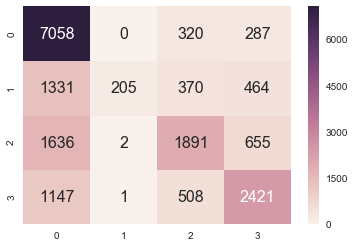

In [320]:
print_metrics(cls, features, labels)

accuracy:  0.579767174947

             precision    recall  f1-score   support

          1       0.61      0.90      0.73      2580
          2       0.31      0.01      0.03       772
          3       0.50      0.35      0.41      1385
          4       0.56      0.52      0.54      1362

avg / total       0.54      0.58      0.53      6099

macro precision:  0.496166636441
micro precision:  0.579767174947

micro recall:  0.579767174947
macro recall:  0.447202502467

micro f1:  0.579767174947
macro f1:  0.426789857045


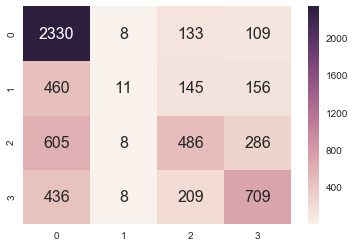

In [321]:
print_metrics(cls, features_test, labels_test)

In [322]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, cls.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance

In [323]:
importances[importances['importance'] > 0].sort_values(by='importance', ascending=False)

,feature,importance
327,token_stretch,2.406882e-02
52,token_kickstarter,1.311483e-02
160,token_artist,7.799656e-03
371,token_would,7.419790e-03
695,token_business,6.705669e-03
445,token_excited,5.834722e-03
1001,token_start,5.829709e-03
3812,token_pin,5.802106e-03
285,token_printed,5.717628e-03
880,token_album,5.358391e-03


Also, we combine tf-idf with other features (see HP tuning notebook).

### LSA

For both of the above configurations of tf-idf, we use TruncatedSVD (with the use of tf-idf also known as LSA).

We reduce dimensionality of tf-idf to:
1. 10 components
2. 25 components
3. 50 components
4. 75 components
5. 100 components
6. 200 components

These components are then combined with other features (see HP tuning notebook) and the best option is selected.

After trying all configurations, we found out that LSA improves overal accuracy by approximately 2%. Also there is a problem that TruncatedSVD uses randomized algorithm. Therefore we get different results after using the same configuration.
However, we got best results with 25 components from tf-idf vectors length of 13 007  (improving accuracy to 74.93%, 74.93% and 75.25% after running TruncatedSVD 3 times).

In [324]:
df = pd.read_csv('data/split/nlp/train_tfidf.csv', index_col=0, encoding='latin1')

In [325]:
from sklearn.decomposition import TruncatedSVD

In [377]:
lsa = TruncatedSVD(n_components=25, random_state=64)

In [378]:
features = pd.DataFrame(lsa.fit_transform(df.iloc[:, 62:]))
features.shape

(18296, 25)

In [328]:
labels = df['class']

In [117]:
df_test = pd.read_csv('data/split/nlp/test_tfidf.csv', index_col=0, encoding='latin1')

In [379]:
features_test = pd.DataFrame(lsa.transform(df_test.iloc[:, 58:]))
features_test.shape

(6099, 25)

In [330]:
labels_test = df_test['class']

In [120]:
df_cv = pd.read_csv('data/split/nlp/cv_tfidf.csv', index_col=0, encoding='latin1')

In [380]:
features_cv = pd.DataFrame(lsa.transform(df_cv.iloc[:, 58:]))
features_cv.shape

(6100, 25)

#### Try prediction with only using LSA components (all projects - not only 25% of them)

In [381]:
cls = GradientBoostingClassifier(random_state=64)

In [382]:
cls.fit(features, labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.588216003498

             precision    recall  f1-score   support

          1       0.61      0.87      0.72      7665
          2       0.97      0.04      0.07      2370
          3       0.54      0.43      0.48      4184
          4       0.56      0.54      0.55      4077

avg / total       0.63      0.59      0.54     18296

macro precision:  0.669032353522
micro precision:  0.588216003498

micro recall:  0.588216003498
macro recall:  0.469769567847

micro f1:  0.588216003498
macro f1:  0.454871739884


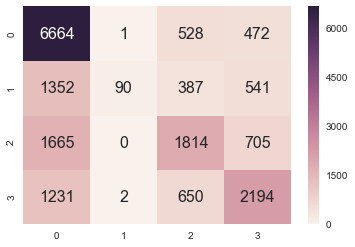

In [383]:
print_metrics(cls, features, labels)

accuracy:  0.554517133956

             precision    recall  f1-score   support

          1       0.60      0.85      0.70      2580
          2       0.52      0.02      0.03       772
          3       0.46      0.36      0.40      1385
          4       0.52      0.49      0.50      1362

avg / total       0.54      0.55      0.51      6099

macro precision:  0.523261284089
micro precision:  0.554517133956

micro recall:  0.554517133956
macro recall:  0.430554837879

micro f1:  0.554517133956
macro f1:  0.410227326757


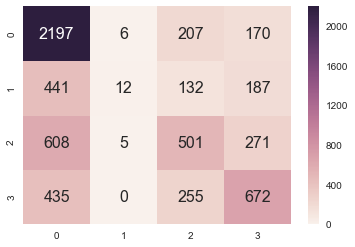

In [384]:
print_metrics(cls, features_test, labels_test)

In [385]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, cls.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance

In [386]:
importances[importances['importance'] > 0].sort_values(by='importance', ascending=False)

,feature,importance
0,0.0,0.076642
11,11.0,0.069233
3,3.0,0.054570
9,9.0,0.053394
2,2.0,0.051269
19,19.0,0.050621
23,23.0,0.045505
24,24.0,0.042118
8,8.0,0.041156
4,4.0,0.040314


In [387]:
features['ratio_running_duration'] = df['ratio_running_duration']
features_test['ratio_running_duration'] = df_test['ratio_running_duration']
features_cv['ratio_running_duration'] = df_cv['ratio_running_duration']

In [388]:
features.to_csv('data/split/nlp/train_lsa.csv')
features_test.to_csv('data/split/nlp/test_lsa.csv')
features_cv.to_csv('data/split/nlp/cv_lsa.csv')

### LDA (Latent Dirichlet Allocation)

In [479]:
# source: http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [483]:
df['tokens'][0][0]

'taken'

In [395]:
# tokens column is treated as string
df['tokens'] = df['tokens'].apply(lambda x: literal_eval(x))

#### Calculate tf

We will not store tf in datasets.

In [484]:
tf_vectorizer = CountVectorizer(preprocessor=' '.join, min_df=0.05)
tf = tf_vectorizer.fit_transform(df['tokens'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [485]:
# test set
tf_test = tf_vectorizer.transform(df_test['tokens'])

In [486]:
# validation set
tf_cv = tf_vectorizer.transform(df_cv['tokens'])

#### Use LDA

In [487]:
lda = LatentDirichletAllocation(random_state=64, n_jobs=-1, n_components=25)

In [488]:
lda.fit(tf)

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=25, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=64,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [489]:
print_top_words(lda, tf_feature_names, 10)

Topic #0: issue black digital color shirt white copy level physical hand
Topic #1: new show city performance york work production 2016 audience stage
Topic #2: product design use quality made high one make also material
Topic #3: film production festival movie director short producer story feature award
Topic #4: get like make want one would time people thing know
Topic #5: service plus 00 100 word 50 reader receive offer post
Topic #6: de la en le un per plus non 000 2016
Topic #7: light camera led blue red night eye color body time
Topic #8: book print reward pledge edition one card add kickstarter backer
Topic #9: art artist work studio piece project create artwork drawing creative
Topic #10: music album song recording record band video sound musician studio
Topic #11: app device phone mobile user use time feature technology home
Topic #12: software system platform user technology application development tool build project
Topic #13: food child kid family fresh grow growing fun tabl

In [490]:
features = pd.DataFrame(lda.transform(tf))

In [491]:
features_test = pd.DataFrame(lda.transform(tf_test))

In [492]:
features_cv = pd.DataFrame(lda.transform(tf_cv))

#### Predict class using only LDA topics (all projects - not only 25% of them)

In [493]:
labels = df['class']
labels_test = df_test['class']

In [494]:
cls = GradientBoostingClassifier(random_state=64)

In [495]:
cls.fit(features, labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.586521644075

             precision    recall  f1-score   support

          1       0.62      0.86      0.72      7665
          2       0.97      0.04      0.08      2370
          3       0.52      0.42      0.46      4184
          4       0.53      0.56      0.55      4077

avg / total       0.63      0.59      0.54     18296

macro precision:  0.662649716819
micro precision:  0.586521644075

micro recall:  0.586521644075
macro recall:  0.470094363191

micro f1:  0.586521644075
macro f1:  0.453328956703


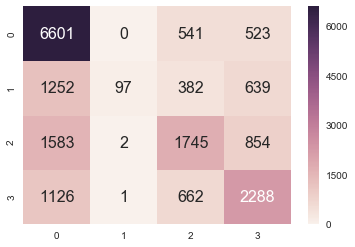

In [496]:
print_metrics(cls, features, labels)

accuracy:  0.557632398754

             precision    recall  f1-score   support

          1       0.61      0.84      0.71      2580
          2       0.37      0.01      0.02       772
          3       0.47      0.37      0.42      1385
          4       0.50      0.51      0.51      1362

avg / total       0.52      0.56      0.51      6099

macro precision:  0.486122384172
micro precision:  0.557632398754

micro recall:  0.557632398754
macro recall:  0.435111924149

micro f1:  0.557632398754
macro f1:  0.411755827208


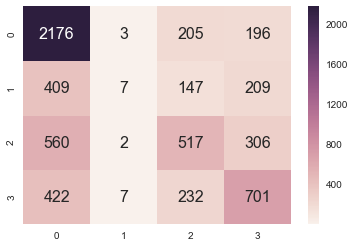

In [497]:
print_metrics(cls, features_test, labels_test)

In [498]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, cls.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance

In [499]:
importances[importances['importance'] > 0].sort_values(by='importance', ascending=False)

,feature,importance
1,1.0,0.060870
8,8.0,0.055920
16,16.0,0.046896
23,23.0,0.046883
12,12.0,0.046714
21,21.0,0.046693
4,4.0,0.046455
19,19.0,0.044557
2,2.0,0.044128
9,9.0,0.041650


In [500]:
features['ratio_running_duration'] = df['ratio_running_duration']
features_test['ratio_running_duration'] = df_test['ratio_running_duration']
features_cv['ratio_running_duration'] = df_cv['ratio_running_duration']

In [501]:
features.to_csv('data/split/nlp/train_lda25.csv')
features_test.to_csv('data/split/nlp/test_lda25.csv')
features_cv.to_csv('data/split/nlp/cv_lda25.csv')

We tested 10 and 25 topics and found out that LDA performs similarly to LSA.

# Problems encountered

As we can see, LDA uses non-english words for topic modeling, which may have bad impact on it's accuracy. This can also be problem for LSA.

For that reason we will repeat most of the steps in this notebook but only using documents fully written in english.

In [507]:
print(str(len(df[(df['lang_1'] == 'en') & (df['lang_2'] == 'en')])) + ' out of ' + str(len(df)) + ' projects are fully written in english.')

16927 out of 18296 projects are fully written in english.
